# Rebalancing with Transaction Costs

The *standard mean-variance (Markowitz) portfolio selection model* determines an optimal investment portfolio that balances risk and expected return. Please refer to the [annotated list of references](../literature.rst#portfolio-optimization) for more background information on portfolio optimization.

In this notebook, we rebalance an existing portfolio to maximize the expected return of the portfolio while constraining the admissible variance (risk) to a given maximum level.  Additionally, we account for *transaction costs* and *fees*:

* The fixed transaction costs occur for each transaction and are independent of the amount that is bought or sold.
* The variable transaction fees are proportional to the traded amount.

In [1]:
# Install dependencies
%pip install numpy scipy gurobipy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gurobipy as gp
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# Hidden cell to avoid licensing messages
# when docs are generated.
with gp.Model():
    pass

Set parameter WLSAccessID


Set parameter WLSSecret


Set parameter LicenseID to value 2443533


WLS license 2443533 - registered to Gurobi GmbH


## Input Data

The following input data is used within the model:

- $S$: set of stocks
- $\mu$: vector of expected returns
- $\Sigma$: PSD variance-covariance matrix
    - $\sigma_{ij}$ covariance between returns of assets $i$ and $j$
    - $\sigma_{ii}$ variance of return of asset $i$

In [4]:
# Import some example data set
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

## Formulation

The model rebalances an existing portfolio. It maximizes the expected return of the new portfolio, constraining the variance of the portfolio not to exceed a specified level, and also accounts for fixed and variable transaction costs and fees.
Mathematically, this results in a convex quadratically constrained mixed-integer optimization problem.

### Model parameters

The following parameters are used within the model:

- $\bar\sigma^2$: maximal admissible variance for the portfolio return
- $x^0_i$: holdings of asset $i$ in the initial portfolio.
Usually, the starting portfolio is given by the previous trading period.
In this notebook, we choose a simple starting portfolio by equally distributing the capital among the assets with the largest returns.

- $\ell>0$: lower bound on transaction size

- $c_i^+, c_i^-$: fixed transaction cost when buying/selling stock $i$
- $f_i^+, f_i^-$: variable transaction cost for buying/selling stock $i$, relative to total investment value

In [5]:
# Values for the model parameters:
V = 4.0  # Maximal admissible variance (sigma^2)
l = 0.001  # Minimal transaction size

# Fixed transaction costs
c_plus = 0.00002 * np.ones(mu.shape)
c_minus = 0.00002 * np.ones(mu.shape)
# Variable transaction fees
f_plus = 0.0002 * np.ones(mu.shape)
f_minus = 0.0002 * np.ones(mu.shape)

# Initial portfolio:  Equally distributed among largest return assets
x0 = pd.Series(index=mu.index, data=np.zeros(mu.shape))
x0.loc[mu.nlargest(20).index] = 1.0 / 20.0

### Decision Variables
We need several sets of decision variables:

1. The proportions of capital invested in the rebalanced portfolio among the considered stocks. The corresponding vector of positions is denoted by $x$ with its component $x_i$ denoting the proportion of capital invested in stock $i$.

The other sets of variables distinguish between buys and sells:

2. The proportions of each stock *bought* and included in the rebalanced portfolio. The corresponding vector of positions is denoted by $x^+$ with its component $x^+_i$ denoting the proportion of capital representing the purchase of stock $i$.

3. The proportions of each stock *sold* from the existing portfolio. The corresponding vector of sales is denoted by $x^-$ with its component $x^-_i$ denoting the proportion of capital representing the sale of stock $i$.

4. Binary variables $b_i^+$ indicating whether or not asset $i$ is *bought*. If  $b_i^+$ is 0, asset $i$ is not bought, that is $x_i \leq x^0_i$. Otherwise, if $b_i^+$ is 1, the investor buys some amount (at least $\ell$) of asset $i$ and $x_i \geq x^0_i + \ell$.

5. Binary variables $b_i^-$ indicating whether or not asset $i$ is *sold*. If  $b_i^-$ is 0, asset $i$ is not sold, that is $x_i \geq x^0_i$. Otherwise, if $b_i^-$ is 1, the investor sells some amount (at least $\ell$) of asset $i$ and $x_i \leq x^0_i - \ell$.

### Variable Bounds

Each position must be between 0 and 1; this prevents leverage and short-selling:

$$0\leq x_i\leq 1 \; , \;  i \in S$$

The buy and sell proportions must be non-negative:

$$ x_i^+, x_i^- \geq 0\; , \, i \in S$$

Variables $b_i^+, b_i^-$ are binary:

$$b_i^+, b_i^- \in \{0,1\} \; , \; i \in S$$

In [6]:
# Create an empty optimization model
m = gp.Model()

# Add variables: x[i] denotes the proportion invested in stock i
x = m.addMVar(len(mu), lb=0, ub=1, name="x")
# Add variables: x_plus[i] denotes the proportion of stock i bought
x_plus = m.addMVar(len(mu), lb=0, ub=1, name="x_plus")
# Add variables: x_minus[i] denotes the proportion of stock i sold
x_minus = m.addMVar(len(mu), lb=0, ub=1, name="x_minus")
# Add variables: b_plus[i]=1 if stock i is bought, and b_plus[i]=0 otherwise
b_plus = m.addMVar(len(mu), vtype=gp.GRB.BINARY, name="b_plus")
# Add variables: b_minus[i]=1 if stock i is sold, and b_minus[i]=0 otherwise
b_minus = m.addMVar(len(mu), vtype=gp.GRB.BINARY, name="b_minus")

###  Constraints

The final proportion of capital invested in a stock in the rebalanced portfolio is obtained by taking into account the buys and sells of this stock as well as the initial holdings in the existing portfolio:

\begin{equation*}
x_i = x^0_i + x^+_i - x^-_i \; , \; i \in S \tag{1}
\end{equation*}

The estimated risk must not exceed a prespecified maximal admissible level of variance $\bar\sigma^2$:

$$x^\top \Sigma x \leq \bar\sigma^2$$

In [7]:
%%capture
# Proportion Changes balance constraint; see formula (1) above
m.addConstr(x == x0.to_numpy() + x_plus - x_minus, name="Position_Balance")

# Upper bound on variance
m.addConstr(x @ Sigma.to_numpy() @ x <= V, name="Variance")

Note that in an optimal solution, at most one of the two variables $x^+_i$ and $x^-_i$ should take a nonzero value for each $i$.

To enforce the minimal transaction size, we use the binary variables $b^+,b^-$ and the following sets of discrete constraints, which will enforce:

\begin{equation*}
x_i^+ \geq \ell\ \text{ if } b_i^+=1 \ \text{ and } x_i^+ = 0 \text{ otherwise} \\
\end{equation*}
\begin{equation*}
x_i^- \geq \ell\ \text{ if } b_i^-=1 \ \text{ and } x_i^- = 0 \text{ otherwise}
\end{equation*}


Ensure that $x_i^+ = 0$ if $b_i^+ = 0$:

\begin{equation*}
x_i^+ \leq b_i^+ \; , \; i \in S\tag{2}
\end{equation*}

Note that we are using that $x_i^+$ has an upper bound of 1 because we cannot buy or sell more than the total capital in one position. Hence, if $b_i^+ = 1$, the above constraint is non-restrictive.


Ensure a minimal transaction size of $\ell$ if asset $i$ is traded:

\begin{equation*}
x_i^+ \geq \ell b_i^+ \; , \; i \in S\tag{3}
\end{equation*}

Hence $b_i^+ = 1$ implies $x_i^+ \geq \ell$. If $b_i^+ = 0$, this constraint is non-restrictive since $x_i^+$ has a lower bound of 0.

Analogously, we define similar constraints for $x_i^-$ and $b_i^-$:

$$ x_i^- \leq b_i^- \; , \; i \in S$$
$$ x_i^- \geq \ell b_i^- \; , \; i \in S$$


Finally, we require that the same asset is not bought and sold at the same time:

$$
b^+_i + b^-_i \leq 1 \; , \; i \in S
$$

In [8]:
%%capture
# Force x_plus, x_minus to 0 if not traded; see formula (2) above
m.addConstr(x_plus <= b_plus, name="Indicator_Buy")
m.addConstr(x_minus <= b_minus, name="Indicator_Sell")
# Minimal buy/sell; see formula (3) above
m.addConstr(x_plus >= l * b_plus, name="Minimal_Buy")
m.addConstr(x_minus >= l * b_minus, name="Minimal_Sell")

# Constraint preventing the simultaneous buy and sell of the same security
m.addConstr(b_plus + b_minus <= 1, name="Mutual_Exclusivity")

Without any costs and fees, we would have the budget constraint $\sum_{i} x_i = 1$ to ensure that all investments sum up to one.
However, we must also pay the resulting fixed costs and variable transaction fees from the capital.

The *fixed costs* occur once per transaction (purchase or sale) and do not depend on the transaction size; hence the fixed costs for asset $i$ are $c_i^+b_i^+ + c_i^-b_i^-$. The *variable fees* are proportional to the transaction size; hence the fees for asset $i$ are $f_i^+x_i^+ + f_i^-x_i^-$.

We include these in the the left-hand side of the equation:

\begin{equation*}
\underbrace{\sum_{i \in S}x_i}_\text{investments}
+ \underbrace{\sum_{i \in S}c_i^+b_i^+
+ \sum_{i\in S}c_i^-b_i^-}_\text{fixed costs for buying and selling}
+ \underbrace{\sum_{i \in S}f_i^+x_i^+
+ \sum_{i \in S}f_i^-x_i^-}_\text{variable fees for buying and selling}
= 1 \tag{4}
\end{equation*}

In [9]:
# Budget constraint: all investments, costs, and fees sum up to 1, see formula (4) above
budget_constr = m.addConstr(
    x.sum() + c_plus @ b_plus + c_minus @ b_minus + f_plus @ x_plus + f_minus @ x_minus
    == 1,
    name="Budget_Constraint",
)

###  Objective Function
The objective is to maximize the expected return of the portfolio:
$$\max_x \mu^\top x $$

In [10]:
# Define objective: Maximize expected return
m.setObjective(mu.to_numpy() @ x, gp.GRB.MAXIMIZE)

We now solve the optimization problem to provable optimality of 1%.
By default, Gurobi uses a [MIP gap](https://docs.gurobi.com/projects/optimizer/en/current/reference/parameters.html#parametermipgap) of 1e-4 (=0.01%), but many real-world application do not need such a tight gap. Hence, we relax this to 1% to improve performance.

In [11]:
m.Params.MIPGap = 0.01
m.optimize()

Set parameter MIPGap to value 0.01


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")


CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]


Thread count: 1 physical cores, 2 logical processors, using up to 2 threads


WLS license 2443533 - registered to Gurobi GmbH


Optimize a model with 2773 rows, 2310 columns and 8316 nonzeros


Model fingerprint: 0xa5e8a251


Model has 1 quadratic constraint


Variable types: 1386 continuous, 924 integer (924 binary)


Coefficient statistics:


  Matrix range     [2e-05, 1e+00]


  QMatrix range    [3e-03, 1e+02]


  Objective range  [7e-02, 6e-01]


  Bounds range     [1e+00, 1e+00]


  RHS range        [5e-02, 1e+00]


  QRHS range       [4e+00, 4e+00]


Presolve removed 1788 rows and 1346 columns


Presolve time: 0.13s


Presolved: 985 rows, 964 columns, 2972 nonzeros


Presolved model has 1 quadratic constraint(s)


Variable types: 482 continuous, 482 integer (482 binary)


Root relaxation: objective 5.916849e-01, 39 iterations, 0.00 seconds (0.00 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0    0.59168    0    1          -    0.59168      -     -    0s


     0     0    0.56263    0    2          -    0.56263      -     -    0s


     0     0    0.43881    0    3          -    0.43881      -     -    0s


     0     0    0.43876    0    4          -    0.43876      -     -    1s


     0     0    0.42962    0    4          -    0.42962      -     -    2s


     0     0    0.42883    0    5          -    0.42883      -     -    2s


     0     0    0.41341    0    6          -    0.41341      -     -    2s


     0     0    0.41340    0    6          -    0.41340      -     -    3s


     0     0    0.40037    0    5          -    0.40037      -     -    3s


     0     0    0.39495    0    5          -    0.39495      -     -    3s


     0     0    0.39494    0    5          -    0.39494      -     -    3s


     0     0    0.39260    0    6          -    0.39260      -     -    3s


     0     0    0.39260    0    6          -    0.39260      -     -    4s


     0     0    0.39238    0    8          -    0.39238      -     -    4s


     0     0    0.38959    0    7          -    0.38959      -     -    4s


     0     0    0.38905    0    8          -    0.38905      -     -    4s


     0     0    0.38818    0    9          -    0.38818      -     -    4s


     0     0    0.38471    0    8          -    0.38471      -     -    4s


     0     0    0.37920    0    6          -    0.37920      -     -    4s


     0     0    0.37838    0    6          -    0.37838      -     -    4s


     0     0    0.37776    0    7          -    0.37776      -     -    4s


     0     0    0.37755    0    8          -    0.37755      -     -    4s


     0     0    0.37675    0    8          -    0.37675      -     -    4s


     0     0    0.37633    0    8          -    0.37633      -     -    4s


     0     0    0.37633    0    8          -    0.37633      -     -    5s


H    0     0                       0.3425836    0.37633  9.85%     -    5s


H    0     0                       0.3494349    0.37633  7.70%     -    6s


H    0     0                       0.3496292    0.37633  7.64%     -    7s


     0     2    0.37633    0    8    0.34963    0.37633  7.64%     -    7s


H   27    27                       0.3524726    0.37631  6.76%   4.7    8s


   104   104    0.35933   16    1    0.35247    0.37613  6.71%   5.6   10s


H  277   216                       0.3531515    0.36921  4.55%   7.3   13s


Explored 279 nodes (2382 simplex iterations) in 13.37 seconds (12.54 work units)


Thread count was 2 (of 2 available processors)


Solution count 5: 0.353151 0.352473 0.349629 ... 0.342584


Optimal solution found (tolerance 1.00e-02)


Best objective 3.531514902694e-01, best bound 3.554402307144e-01, gap 0.6481%


Display basic solution data, costs, and fees. For clarity, we round all solution quantities to five digits.

In [12]:
print(f"Expected return:  {m.ObjVal:.6f}")
print(f"Variance:         {x.X @ Sigma @ x.X:.6f}")
print(f"Solution time:    {m.Runtime:.2f} seconds\n")
print(f"Fixed costs:      {c_plus @ b_plus.X + c_minus @ b_minus.X:.6f}")
print(f"Variable fees:    {f_plus @ x_plus.X + f_minus @ x_minus.X:.6f}\n")
print(
    f"Number of positions: before {np.count_nonzero(x0[x0>1e-5])}, after {np.count_nonzero(x.X[x.X>1e-5])}"
)
print(
    f"Number of trades:    {sum(b_plus.X.round()) + sum(b_minus.X.round())} ({sum(b_plus.X.round())} buy(s), {sum(b_minus.X.round())} sell(s))\n"
)

# Print all assets with either a non-negligible position or transaction
df = pd.DataFrame(
    index=mu.index,
    data={
        "position": x.X,
        "transaction": x_plus.X - x_minus.X,
    },
).round(6)
df[(df["position"] > 1e-5) | (abs(df["transaction"]) > 1e-5)].sort_values(
    "position", ascending=False
)

Expected return:  0.353151
Variance:         4.000000
Solution time:    13.37 seconds

Fixed costs:      0.000620
Variable fees:    0.000331

Number of positions: before 20, after 19
Number of trades:    31.0 (13.0 buy(s), 18.0 sell(s))



position  transaction
LLY   0.251369     0.251369
PGR   0.130347     0.130347
NVDA  0.110375     0.060375
KDP   0.068958     0.068958
AVGO  0.057072     0.007072
NOC   0.054354     0.054354
ORLY  0.051407     0.051407
ODFL  0.041573     0.041573
TMUS  0.039788     0.039788
TTWO  0.037309     0.037309
DPZ   0.034631     0.034631
KR    0.030179     0.030179
NFLX  0.022457    -0.027543
UNH   0.019021     0.019021
DXCM  0.018191    -0.031809
TSLA  0.013521    -0.036479
ENPH  0.010658    -0.039342
MOH   0.007822    -0.042178
FICO  0.000010    -0.049990
CDNS  0.000008    -0.049992
MU    0.000000    -0.050000
AMD   0.000000    -0.050000
NOW   0.000000    -0.050000
KLAC  0.000000    -0.050000
AMAT  0.000000    -0.050000
MPWR  0.000000    -0.050000
AXON  0.000000    -0.050000
EPAM  0.000000    -0.050000
FANG  0.000000    -0.050000
PANW  0.000000    -0.050000
LRCX  0.000000    -0.050000

## Comparison with the unconstrained portfolio

We can also optimize the portfolio without considering the transaction costs and compare the resulting portfolios.

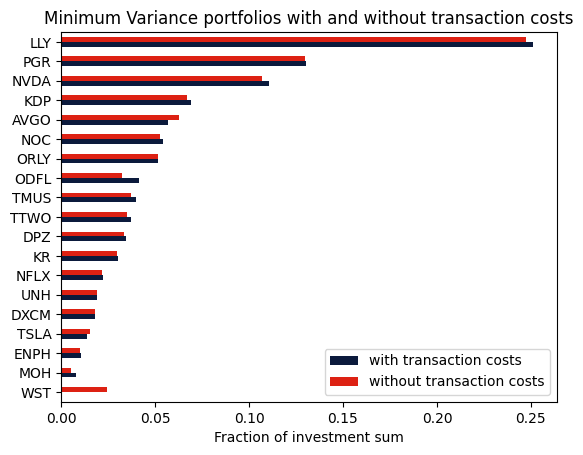

In [13]:
# remove budget constraint
m.remove(budget_constr)
# add new budget constraint without costs
m.addConstr(x.sum() == 1, name="Budget_Constraint")
m.params.OutputFlag = 0
m.optimize()

# retrieve and display solution data
positions_no_costs = pd.Series(name="Position", data=x.X, index=mu.index)
mask = (df["position"] > 1e-5) | (positions_no_costs > 1e-5)
df2 = pd.DataFrame(
    index=df[mask].index,
    data={
        "with transaction costs": df["position"],
        "without transaction costs": positions_no_costs,
    },
).sort_values("with transaction costs", ascending=True)

axs = df2.plot.barh(color=["#0b1a3c", "#dd2113"])
axs.set_xlabel("Fraction of investment sum")
plt.title("Minimum Variance portfolios with and without transaction costs")
plt.show()

## Takeaways
* Rebalancing is modeled in the same way as when we start from an all-cash position by considering the difference between the initial holdings and the final position in the rebalanced portfolio instead of just the final position.
* When rebalancing, we can also sell positions; when starting from an all-cash position, we can only buy (unless we allow short-selling). We introduced additional decision variables for this.
*  Transaction costs and fees can be incorporated into the basic budget constraint.
* Fixed costs are independent of the traded amount and can be modeled using binary decision variables.
* Variable fees are proportional to the traded amount and can be modeled using continuous decision variables.